In [1]:
import numpy as np
import math

G = 6.674e-11
manually_set = 0     #set this to 1 if you want to give the values from terminal, otherwise read from input_raw.txt
starting_time = 0       #starting time added to the input_converted file
center_of_mass = 0      #set this to True if you want the coordinates to be in the center of mass

#mass is always set (we can change it in the future but I think it's the simplest way)
#now we are left with radius and velocity
set_radius = True       #if this is True the radius will be set to 1 ua (which can be changed in the code). Then the velocity will be calculated accordingly (to get G=1)
#if this is False the velocity will be set to 1000m/s and the radius will be calculated accordingly

mass = []
x = []
y = []
z = []
vx =[]
vy = []
vz = []
r = []

if manually_set == True:
    number_of_bodies = input("Enter the number of bodies:")
    for i in range(int(number_of_bodies)):
        mass.append(float(input("Enter mass:")))
        x.append(float(input("Enter x")))
        y.append(float(input("Enter y")))
        z.append(float(input("Enter z")))
        vx.append(float(input("Enter vx")))
        vy.append(float(input("Enter vy")))
        vz.append(float(input("Enter vz")))
    
        r.append(np.sqrt(x[i]**2 + y[i]**2 + z[i]**2))      #non so se serve
else:
    mass, x, y, z, vx, vy, vz = np.loadtxt("input_raw.txt", delimiter=" ", comments="#", dtype="float").T
    number_of_bodies = len(mass)

mass_x = [a * b for a, b in zip(mass, x)]      #mass times coordinate x
mass_y = [a * b for a, b in zip(mass, y)]      #mass times coordinate y
mass_z = [a * b for a, b in zip(mass, z)]      #mass times coordinate z
cm_x = np.sum(mass_x)/sum(mass)
cm_y = np.sum(mass_y)/sum(mass)
cm_z = np.sum(mass_z)/sum(mass)

mass_internal = mass[0]     #use the first mass as unit, you can choose another one

if set_radius == True:
    r_internal = 149597870700       #m, 1 ua, you can change this to be anything (but 0)
    v_internal = np.sqrt(G*mass_internal/r_internal)

else:
    v_internal = 1000       #m/s
    r_internal = G*mass_internal/v_internal**2

t_internal = r_internal/v_internal


new_mass = mass/mass_internal

if center_of_mass == True:
    new_x = (x-cm_x)/r_internal
    new_y = (y-cm_y)/r_internal
    new_z = (z-cm_z)/r_internal
else:
    new_x = x/r_internal
    new_y = y/r_internal
    new_z = z/r_internal

new_vx = vx/v_internal
new_vy = vy/v_internal
new_vz = vz/v_internal

with open("input_converted.txt", "w") as f:     #file ready to be given to the C code
    print(number_of_bodies, starting_time, sep="\n", file=f)
    np.savetxt(f, np.column_stack([new_mass, new_x, new_y, new_z, new_vx, new_vy, new_vz]), delimiter=" ")


    


In [2]:
#I think this works only for windows, change the command inside os.system 
#make sure that the txt input file is good
import os
#os.system("cmd /c g++ nbody_sh1.C")
print(2*np.pi*t_internal)
t = str(100)
os.system("cmd /c a.exe -o 1 -t " + t + " < input_converted.txt > output_converted.txt")

31467329.478665963


0

In [3]:
def Extract(lst, n):        #extract from a list of lists the nth number of the sublist
    return [item[n] for item in lst]


with open("output_converted.txt") as f:
    lines = f.readlines()

n = int(lines[0])        #number of bodies, I need it to tell how many lines to skip (it repeats every n+2)
l = len(lines)      #dividing this by the number of bodies + 2 gives me the number of cycles
cycles = int(l/(n+2))

time = lines[1::n+2]      #start from line 0 and read every 5, time

data = []*l
for i in range(cycles):
    for j in range(n):
        data.append(lines[i*(n+2)+2+j].split())     #here I take the third to the n+3rd line for the first cycle, where n is the number of bodies, then I take the second cycle, which goes from n+2 to 2n+2, remember that the idexes in range() start from 0

#print(data)            #check what's inside to better understand

mass = np.float_(Extract(data, 0))      #this is a cycles*n long array, which means that every nth element divides the array in various cycles
                                        #for example for 3 bodies the first 3 elements are the masses of the bodies at t1, the second 3 elements are the mass of the bodies at t2 etc
x = np.float_(Extract(data, 1))         #same thing for everything else, but instead of taking the first [0] element of each sublist, we take the 1 for x, 2 for y etc
y = np.float_(Extract(data, 2))
z = np.float_(Extract(data, 3))
vx = np.float_(Extract(data, 4))
vy = np.float_(Extract(data, 5))
vz = np.float_(Extract(data, 6))
#7 values from 0 to 6

#print(x)               #here there should be only the corresponding element from data


real_mass = mass*mass_internal
real_x = x*r_internal
real_y = y*r_internal
real_z = z*r_internal
real_vx = vx*r_internal
real_vy = vy*r_internal
real_vz = vz*r_internal

#print(x, real_x)


with open("output_raw.txt", 'w') as f:
    np.savetxt(f, np.column_stack([real_mass, real_x, real_y, real_z, real_vx, real_vy, real_vz]), delimiter=" ")       #first write the real values in a file



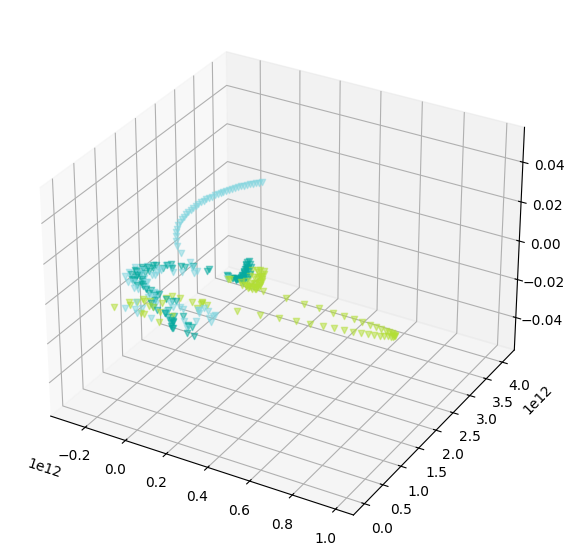

500818103.24310017


In [4]:
#plot orbita ellitica 
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as mcolors
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

    
dati=np.genfromtxt('output_raw.txt', delimiter=' ', usecols=range(1,4), invalid_raise=False)
dati_1=dati[::number_of_bodies]
i=0

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")


for j in range(number_of_bodies):
    c = mcolors.to_hex((random.random(), random.random(), random.random()))
    for i in range(len(dati_1)-1):
        ax.scatter3D(dati[j::number_of_bodies][i,0], dati[j::number_of_bodies][i,1], dati[j::number_of_bodies][i,2], color=c, alpha=0.5, marker="v")
    i=i+1
    
plt.show()
print(int(t)*t_internal)